In [11]:
from ultralytics import YOLO
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import torch
from PIL import Image
from strhub.data.module import SceneTextDataModule

%matplotlib inline

os.environ['USE_TORCH'] = '1'

# Load model
model = YOLO("./new_models/best.pt")
reader = easyocr.Reader(['en'], gpu=True)

# Load model and image transforms
parseq = torch.hub.load('baudm/parseq', 'parseq', pretrained=True).eval()
img_transform = SceneTextDataModule.get_transform(parseq.hparams.img_size)

Using cache found in C:\Users\lucki/.cache\torch\hub\baudm_parseq_main


In [12]:
# from PIL
im1 = Image.open(
    r"C:\Users\lucki\Downloads\tester.v2i.yolov8_2\test\images\55_jpg.rf.02f2e4edc0846207d2122c091302cbde.jpg")

# from list of PIL/ndarray
results = model.predict(source=im1, augment=True)


0: 416x640 1 address, 1 dob, 1 name, 1 state, 143.7ms
Speed: 1.0ms preprocess, 143.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


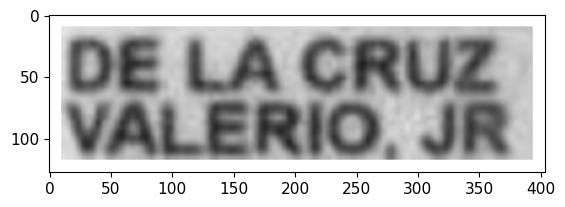

EasyOCR :  ['DE LA CRUZ', 'WALERIO_', 'JR']
Parseq :  ['VALERIO.JR']


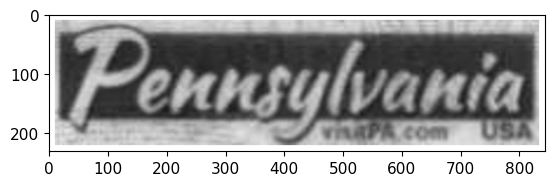

EasyOCR :  ['Pensylvania', 'con', 'Usa']
Parseq :  ['Pennsylvania']


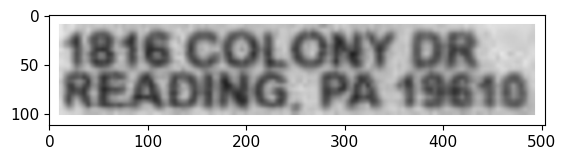

EasyOCR :  ['4816 COLOMY DR', 'READING', 'PA 19610']
Parseq :  ['READING.PA19610']


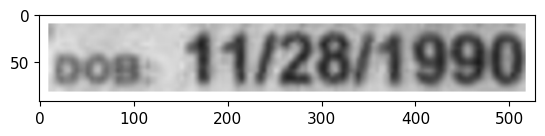

EasyOCR :  ['poh', '11/28/1990']
Parseq :  ['DOB:11/28/1990']


In [23]:
boxes = results[0].boxes
for box in boxes:

    ### Image processing ###
    # crop each box
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    cropped = im1.crop((x1, y1, x2, y2))
    cropped = cropped.resize((cropped.width*4, cropped.height*4))

    # add padding to cropped image 
    cropped = np.array(cropped)

    # make image black and white
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # convert to 3 channels
    cropped = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)


    cropped = cv2.copyMakeBorder(cropped, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    cropped = Image.fromarray(cropped)

    plt.imshow(cropped)
    plt.show()


    ### OCR ###

    # EasyOCR
    print("EasyOCR : ", reader.readtext(np.array(cropped), detail=0))

    # Parseq
    logits = parseq(img_transform(cropped).unsqueeze(0))
    logits.shape  # torch.Size([1, 26, 95]), 94 characters + [EOS] symbol

    # greedy decoding
    pred = logits.softmax(-1)
    label, confidence = parseq.tokenizer.decode(pred)
    print("Parseq : ", label)
